In [1]:
from qiskit_optimization.applications import Maxcut, Tsp
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from functools import partial

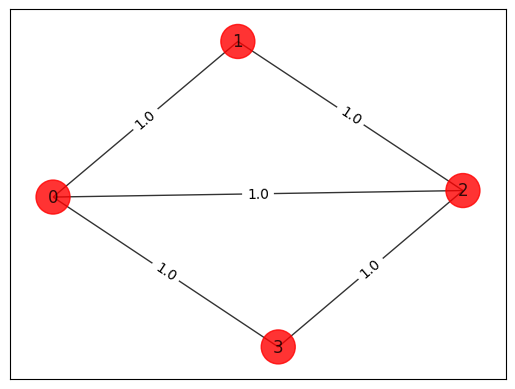

In [2]:

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1).tolist())
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


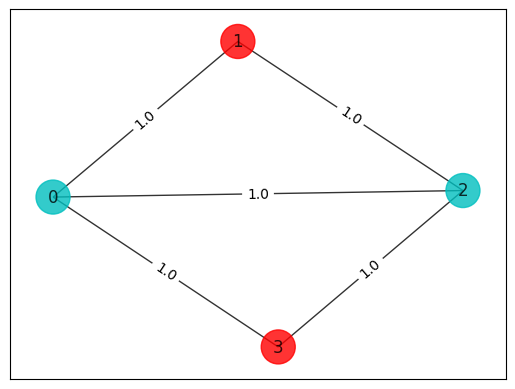

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [6]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [7]:
cost_h, mixer_h = qaoa.min_vertex_cover(G, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (0.5) [Z1]
+ (0.5) [Z3]
+ (1.25) [Z0]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [12]:

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("default.qubit", wires=3)

@partial(qml.cut_circuit, auto_cutter=True) 
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 8
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(f"Cost after step {i + 1}: {cost_function(params)}")

print("Optimal Parameters")
print(params)


@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (39).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")
/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (38).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


Cost after step 1: 0.15800891151564067
Cost after step 2: -0.35569492187712226
Cost after step 3: -0.5776503567435859
Cost after step 4: -0.6743944950716921
Cost after step 5: -0.7227852621334543
Cost after step 6: -0.7510242890587989
Cost after step 7: -0.7698935697206393
Cost after step 8: -0.7839521609376838
Optimal Parameters
[[0.64392534 0.39534216]
 [0.36306365 0.73737272]]


WireError: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {3}

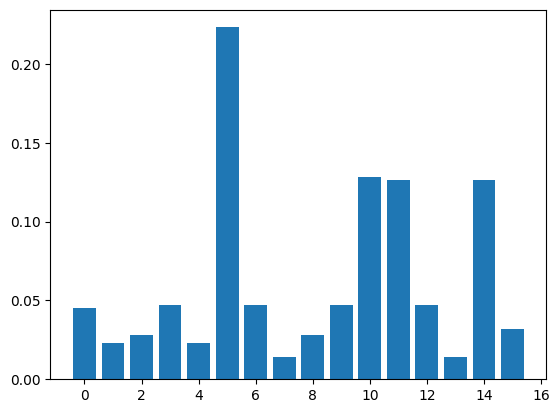

In [13]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()